# Exploring Quantum Classification Library

This notebook offers a high-level walkthrough of solving classification problems using the [quantum machine learning library](https://docs.microsoft.com/quantum/libraries/machine-learning/) that is part of the Microsoft Quantum Development Kit. 
It does not require any familiarity with the basic of quantum computing to follow.

The companion Q# notebook [Inside Quantum Classifiers](./InsideQuantumClassifiers.ipynb) offers a deep dive in the internals of a simple quantum classifier and several exercises on implementing it from scratch. 

> <font color="red">This notebook contains some heavy computations, and might take a fair amount of time to execute. 
    Precomputed cell outputs are included - you might want to study these before you opt to re-run the cells.</font>

## Setup

To start with, execute this cell using Ctrl+Enter (or ⌘+Enter on a Mac). This is necessary to prepare the environment, import the Q# libraries and operations we'll use later in the tutorial, and configure the plotting routines. If any Python packages are reported as missing, install them.

In [1]:
import json
import math
import random
from typing import List

import numpy as np
from matplotlib import pyplot
pyplot.style.use('ggplot')

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

# Plotting configuration
cases = [(0, 0), (0, 1), (1, 1), (1, 0)]
markers = [
    '.' if actual == classified else 'x'
    for (actual, classified) in cases
]
colors = ['blue', 'blue', 'red', 'red']

# Q# configuration and necessary imports
import qsharp
qsharp.packages.add("Microsoft.Quantum.MachineLearning::0.11.2004.2825")
qsharp.reload()

import Microsoft.Quantum.Kata.QuantumClassification as QuantumClassification

print()
print("Setup complete!")

Adding package Microsoft.Quantum.MachineLearning::0.11.2004.2825.
Setup complete!


## The Data

The first step of solving a classification problem is preparing the training and validation datasets.

> In the first part of the tutorial we will use artificially generated data, in which the two classes can be separated using two lines that go through the (0, 0) point. 
This mirrors the data used in the [deep dive tutorial](./InsideQuantumClassifiers.ipynb). 
A real classification problem will load real data instead, but this choice of artificial data allows to construct a simple quantum classifier by hand, which will be helpful for a deep dive in the classifier structure.

In [2]:
def generate_data (samples_number : int, separation_angles : List[float]):
    """Generates data with 2 features and 2 classes separable by a line that goes through the origin"""
    features = []
    labels = []
    for i in range(samples_number):
        sample = [random.random(), random.random()]
        angle = math.atan2(sample[1], sample[0])
        features.append(sample)
        labels.append(0 if angle < separation_angles[0] or angle > separation_angles[1] else 1)
    
    data = { 'Features' : features, 'Labels' : labels }
    return data

# generate training and validation data using the same pair of separation angles
separation_angles = [math.pi / 6, math.pi / 3]
training_data = generate_data(150, separation_angles)
validation_data = generate_data(50, separation_angles)

In [3]:
def plot_data (features : list, actual_labels : list, classified_labels : list = None, extra_lines : list = None):
    """Plots the data, labeling it with actual labels if there are no classification results provided, 
    and with the classification results (indicating their correctness) if they are provided.
    """
    samples = np.array(features)
    pyplot.figure(figsize=(8, 8))
    for (idx_case, ((actual, classified), marker, color)) in enumerate(zip(cases, markers, colors)):
        mask = np.logical_and(np.equal(actual_labels, actual), 
                              np.equal(actual if classified_labels == None else classified_labels, classified))
        if not np.any(mask): continue
        pyplot.scatter(
            samples[mask, 0], samples[mask, 1],
            label = f"Class {actual}" if classified_labels == None else f"Was {actual}, classified {classified}",
            marker = marker, s = 300, c = [color],
        )
    # Add the lines to show the true classes boundaries, if provided
    if extra_lines != None:
        for line in extra_lines:
            pyplot.plot(line[0], line[1], color = 'gray')
    pyplot.legend()

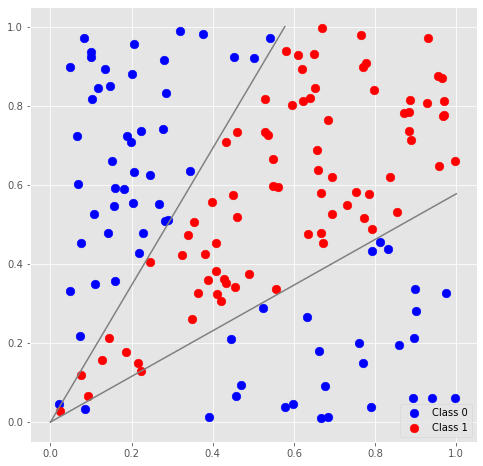

In [4]:
def separation_endpoint (angle : float) -> (float, float):
    if (angle < math.pi / 4):
        return (1, math.tan(angle))
    return (1/math.tan(angle), 1)

# Set up lines that show class separation
separation_lines = list(zip([(0,0), (0,0)], list(map(separation_endpoint, separation_angles))))
extra_lines = []
for line in separation_lines:
    extra_lines.append([[line[0][0], line[1][0]], [line[0][1], line[1][1]]])
    
plot_data(training_data['Features'], training_data['Labels'], extra_lines = extra_lines)

## Training

Now that the data is ready, we can get to the interesting part: training the model! 

> This code calls Q# operation `TrainLinearlySeparableModel` defined in the `Backend.qs` file. 
This operation is a wrapper for the library operation [TrainSequentialClassifier](https://docs.microsoft.com/qsharp/api/qsharp/microsoft.quantum.machinelearning.trainsequentialclassifier). 
It provides all "quantum" details, such as the model structure.
We will take a closer look at these details in the [deep dive tutorial](./InsideQuantumClassifiers.ipynb).

In [5]:
(parameters, bias) = QuantumClassification.TrainLinearlySeparableModel.simulate(
    trainingVectors = training_data['Features'],
    trainingLabels = training_data['Labels'],
    initialParameters = [[0.0], [0.33], [0.66], [1.0], [1.33], [1.66], [2.0], [2.33], [2.66], [3.0]]
)

Training complete, found optimal parameters: [1.6150475625], -0.43665000000000004 with 3 misses


## Validation

Let's validate our training results on a different data set, generated with the same distribution.

> This code calls Q# operation `ClassifyLinearlySeparableModel` defined in the `Backend.qs` file. 
This operation is a wrapper for the library operations [EstimateClassificationProbabilities](https://docs.microsoft.com/qsharp/api/qsharp/microsoft.quantum.machinelearning.estimateclassificationprobabilities) 
and [InferredLabels](https://docs.microsoft.com/qsharp/api/qsharp/microsoft.quantum.machinelearning.inferredlabels). 
Again, we will take a closer look at the details of what's going on in the [deep dive tutorial](./InsideQuantumClassifiers.ipynb).

In [6]:
# Validation parameters
tolerance = 0.005
nMeasurements = 10_000

# Classify validation data set using training results
classified_labels = QuantumClassification.ClassifyLinearlySeparableModel.simulate(
    samples = validation_data['Features'],
    parameters = parameters, bias = bias,
    tolerance = tolerance, nMeasurements = nMeasurements
)

# Calculate miss rate
mask = np.not_equal(validation_data['Labels'], classified_labels)
miss_count = np.array(classified_labels)[np.where(mask)].size
miss_rate = miss_count / len(classified_labels)
print(f"Miss rate: {miss_rate:0.2%}")

Miss rate: 0.00%


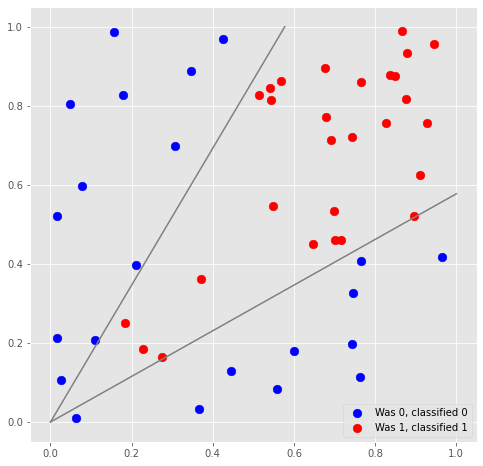

In [7]:
plot_data(validation_data['Features'], validation_data['Labels'], classified_labels, extra_lines)

## Under the Hood

So far everything we've seen looked perfectly normal, there was no noticeable difference between using a quantum classification library and a traditional machine learning library. 
Let's take the same data and see what is going on under the hood: what does a quantum classifier model look like, what are the parameters it uses and how it can be trained.

**Go on to the [deep dive tutorial](./InsideQuantumClassifiers.ipynb)**.

## What's Next?

This tutorial covered classifying artificial data, taking advantage of its simple structure. Classifying real data will require more complex models - same as in traditional machine learning.

* Check out [introduction to quantum machine learning](https://docs.microsoft.com/quantum/libraries/machine-learning/) at Microsoft Quantum Development Kit documentation, which features a more interesting example - classifying half-moons dataset.
* [Quantum machine learning samples](https://github.com/microsoft/Quantum/tree/master/samples/machine-learning) offer examples of classifying several more datasets.